# How does the performance change with the number of task descriptions

In [12]:
import os
import json
import tqdm
from pathlib import Path
import textwrap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.transforms as transforms
import seaborn as sns

from llm_elicited_priors.plotting import graph_theme
from llm_elicited_priors.utils import load_nested_dict_to_pandas

import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('retina')

In [13]:
width = 7.1413/0.75
colwidth = 3.433071
linewidth = 7.12598

In [14]:
RESULTS_PATH = Path(os.path.join(
    "results", "elicitation_varied_numbers_of_descriptions"
))

In [15]:
number_of_labels_to_plot = [5, 10, 20, 30, 40, 50]
n_priors_to_plot = [4,  6,  8, 10]

In [16]:
def load_result_dicts(path: Path):
    results_files = [
        f for f in os.listdir(path) 
        if (f.endswith(".json") and f.startswith("prior_no_prior"))
    ]
    print(f"Loading {len(results_files)} files from {path}")
    results_dicts = [
        json.load(open(os.path.join(path, f), "r"))
        for f in results_files
    ]

    return results_files, results_dicts

In [17]:
def result_dicts_to_df(results_files, results_dicts):
    results_dfs = [
        load_nested_dict_to_pandas(
            results_dict, level_names=[
                "dataset", 
                "n_priors", 
                "run", 
                "n_data_points_seen", 
                "prior_type",
            ]
        ).assign(results_file_name=results_file_name)
        
        for results_dict, results_file_name in zip(results_dicts, results_files)
    ]

    results_df = pd.concat(
        results_dfs
    ).astype(
        {
            "n_data_points_seen": int,
        }
    )

    return results_df

In [18]:
# results directory for each model
model_results_dir_dict = {
    "gpt_3_5_turbo": "gpt-3-5-turbo-0125",
    "deepseek_32b_q4": "deepseek-r1-32b-int4",
}

results_df = pd.DataFrame()

for model_name, model_results_dir in tqdm.tqdm(
    model_results_dir_dict.items(), desc="Loading results"
):
    # loading the results from the dictionaries to a dataframe
    model_results_df = (
        result_dicts_to_df(
            # loading the files to dictionaries
            *load_result_dicts(RESULTS_PATH.joinpath(model_results_dir))
        )
    ).assign(
        prior_type=model_name
    )

    results_df = pd.concat(
        [
            results_df,
            model_results_df
        ]
    )

Loading results:   0%|          | 0/2 [00:00<?, ?it/s]

Loading 360 files from results/elicitation_varied_numbers_of_descriptions/gpt-3-5-turbo-0125


Loading results:  50%|█████     | 1/2 [00:12<00:12, 12.14s/it]

Loading 360 files from results/elicitation_varied_numbers_of_descriptions/deepseek-r1-32b-int4


Loading results: 100%|██████████| 2/2 [00:26<00:00, 13.10s/it]


In [19]:
dataset_metric_to_plot = {
    "fake_data": "mse",
    "uti": "accuracy",
    "breast_cancer": "accuracy",
    "california_housing": "mse",
    "heart_disease": "accuracy",
    "wine_quality": "accuracy",
    "diabetes": "mse",
    "hypothyroid": "accuracy",

}
dataset_rename = {
    "fake_data": r"$y = 2 x_1 - x_2 + x_3$",
    "uti": "UTI",
    "breast_cancer": "Breast Cancer",
    "california_housing": "California Housing",
    "heart_disease": "Heart Disease",
    "wine_quality": "Wine Quality",
    "diabetes": "Diabetes",
    "hypothyroid": "Hypothyroid",
}


In [20]:
accuracy_results_line_plot = (
    results_df
    # get the correct metric for each dataset
    .assign(
        metrics_to_plot=lambda df: (
            df.apply(
                lambda row: row[dataset_metric_to_plot[row["dataset"]]],
                axis=1
            )
        )
    )
    .assign(
        metrics_to_plot=lambda x: x["metrics_to_plot"].apply(
            lambda x: np.array(x).reshape(-1)),
    )
    .astype({"n_priors": int})
    .set_index(["dataset", "n_priors", "n_data_points_seen", "prior_type", "run"])
    [["metrics_to_plot"]]
    .reset_index()
    .reset_index(drop=True)
    .replace({"dataset": dataset_rename})
    .loc[lambda df: df["n_data_points_seen"].isin(number_of_labels_to_plot)]
    .loc[lambda df: df["n_priors"].isin(n_priors_to_plot)]
    .assign(metrics_to_plot=lambda x: x["metrics_to_plot"].apply(lambda x: x.mean()))
)
accuracy_results_line_plot

,dataset,n_priors,n_data_points_seen,prior_type,run,metrics_to_plot
0,Breast Cancer,8,5,gpt_3_5_turbo,8,0.863654
1,Breast Cancer,8,10,gpt_3_5_turbo,8,0.864516
2,Breast Cancer,8,20,gpt_3_5_turbo,8,0.854155
3,Breast Cancer,8,30,gpt_3_5_turbo,8,0.882460
4,Breast Cancer,8,40,gpt_3_5_turbo,8,0.867626
...,...,...,...,...,...,...
4309,UTI,6,10,deepseek_32b_q4,9,0.598713
4310,UTI,6,20,deepseek_32b_q4,9,0.687044
4311,UTI,6,30,deepseek_32b_q4,9,0.681188
4312,UTI,6,40,deepseek_32b_q4,9,0.664687


In [21]:
method_names = {
    "uninformative": "Uninformative", 
    "gpt_3_5_turbo": r"GPT-3.5-turbo", 
    "gpt_4_turbo_prior": r"GPT-4-turbo", 
    "deepseek_32b_q4": r"DeepSeek-R1-32B-Q4",
}

method_palette = {
    method_names["uninformative"]: "xkcd:bright orange",
    method_names["gpt_3_5_turbo"]: "xkcd:bright blue",
    method_names["gpt_4_turbo_prior"]: "xkcd:purple",
    method_names["deepseek_32b_q4"]: "xkcd:kelly green",
}

markers = {
    method_names["uninformative"]: "o",
    method_names["gpt_3_5_turbo"]: "X",
    method_names["gpt_4_turbo_prior"]: "P",
    method_names["deepseek_32b_q4"]: "s",

}

dashes = {
    method_names["uninformative"]: (2,1,1,1),
    method_names["gpt_3_5_turbo"]: (1, 0), 
    method_names["gpt_4_turbo_prior"]: (1, 0),
    method_names["deepseek_32b_q4"]: (1, 0),
}


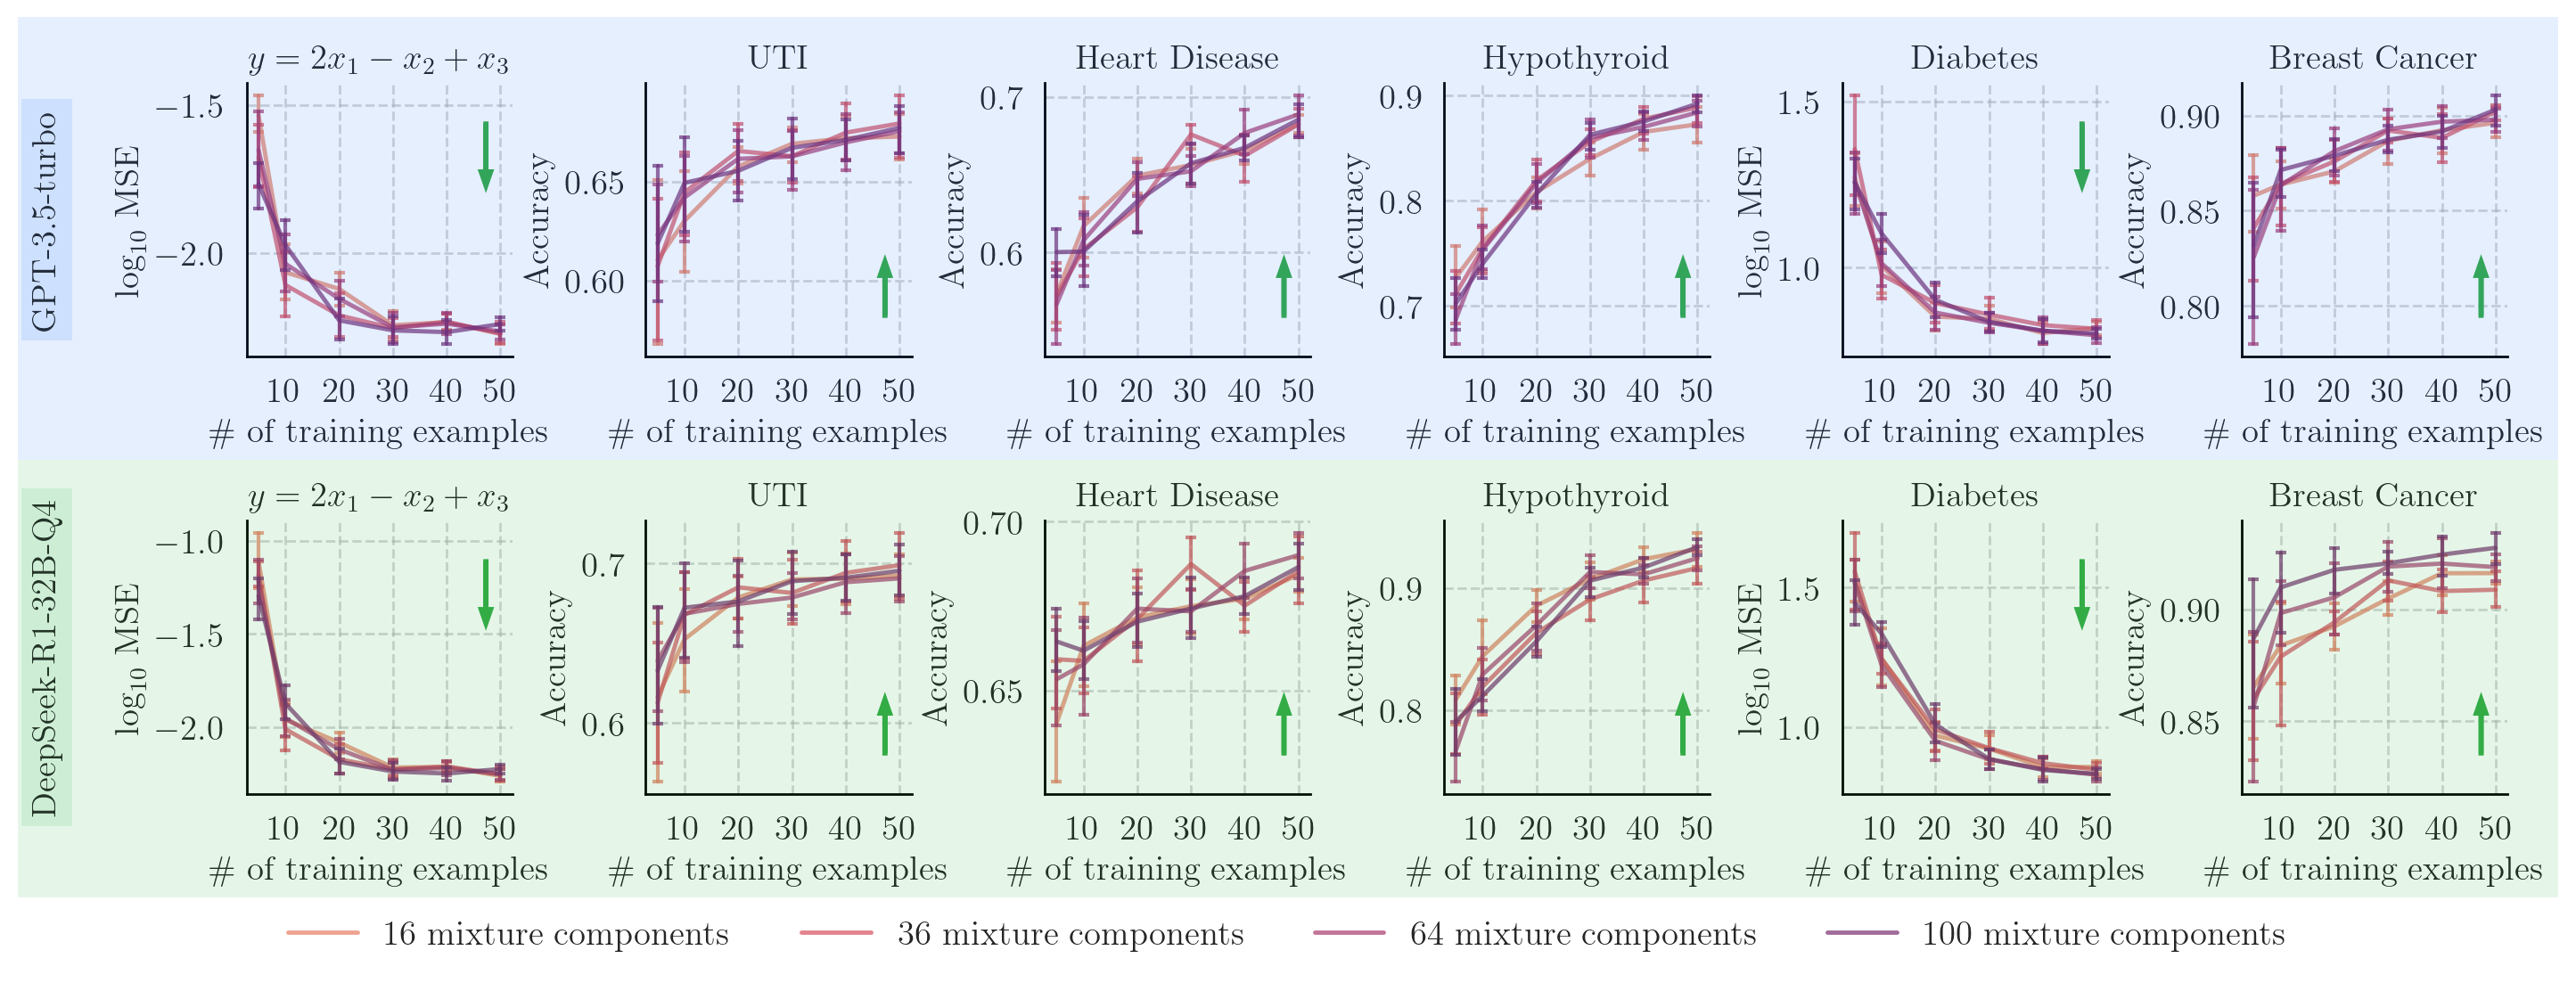

In [22]:
methods_to_plot = [
    #"uninformative",
    #"informative",
    "gpt_3_5_turbo",
    "deepseek_32b_q4",
]

fontsize = 14

linewidth_on_plot = 1.75
alpha = 0.7

datasets_to_plot = [
    r"$y = 2 x_1 - x_2 + x_3$",
    "UTI",
    "Heart Disease",
    "Hypothyroid",
    "Diabetes",
    "Breast Cancer",
    #"California Housing",
    #"Wine Quality",
]

n_priors_order = np.sort(accuracy_results_line_plot["n_priors"].unique())

palette = sns.color_palette(
    "flare", 
    n_colors=len(accuracy_results_line_plot["n_priors"].unique())
)

with graph_theme():
    plt.close()

    fig, axes = plt.subplots(
        len(methods_to_plot), len(datasets_to_plot), 
        figsize=(2*linewidth, len(methods_to_plot)*0.6*linewidth/1.618)
    )

    for row, method_to_plot in enumerate(methods_to_plot):

        for nax, (dataset, ax) in enumerate(
            zip(
                datasets_to_plot,
                axes[row, :],
            )
        ):

            ax = sns.lineplot(
                data=(
                    accuracy_results_line_plot
                    .loc[lambda df: df["prior_type"] == method_to_plot]
                    .query("dataset == @dataset")
                    .replace({"prior_type": method_names})
                    .loc[lambda df: df["n_priors"].isin(n_priors_order)]
                    .assign(
                        metrics_to_plot=lambda x: 
                        np.log10(x["metrics_to_plot"].astype(float)) 
                        if dataset in ["California Housing", r"$y = 2 x_1 - x_2 + x_3$", "Diabetes"]
                        else x["metrics_to_plot"]
                    )
                ),
                x="n_data_points_seen",
                y="metrics_to_plot",
                hue="n_priors",
                hue_order=n_priors_order,
                palette=palette,
                alpha=alpha,
                err_style="bars",
                errorbar=("ci", 95),
                err_kws=dict(
                    capsize=2,
                    capthick=1.5,
                    elinewidth=1.5,
                    linewidth=1.5,
                ),
                markersize=6,
                linewidth=linewidth_on_plot,
                ax=ax,
                legend=False,
            )

            if nax == 0:
                if dataset in ["California Housing", r"$y = 2 x_1 - x_2 + x_3$", "Diabetes"]:
                    ax.set_ylabel(r"$\log_{10}$ MSE", fontsize=fontsize)
                else:
                    ax.set_ylabel("Accuracy", fontsize=fontsize)
            else:
                if dataset in ["California Housing", r"$y = 2 x_1 - x_2 + x_3$", "Diabetes"]:
                    ax.set_ylabel(r"$\log_{10}$ MSE", fontsize=fontsize)
                else:
                    ax.set_ylabel("Accuracy", fontsize=fontsize)
            ax.set_xlabel("\# of training examples", fontsize=fontsize)
            ax.tick_params(axis="both", labelsize=fontsize)
            ax.set_title(dataset, fontsize=fontsize)
            ax.set_xticks(np.arange(0, 51, 10))

            y = (
                0.15 
                if dataset not in ["California Housing", r"$y = 2 x_1 - x_2 + x_3$", "Diabetes"] 
                else 0.85
            )
            dy = (
                0.075*(0.8/0.3)*(1.4/1.6)*5/6
                if dataset not in ["California Housing", r"$y = 2 x_1 - x_2 + x_3$", "Diabetes"] 
                else -0.075*(0.8/0.3)*(1.4/1.6)
            )
            ax.arrow(
                x=0.9, y=y, 
                dx=0.0, dy=dy,
                head_width=0.05/(1.25*1.33)*6/5, 
                head_length=0.025*(1.25*1.33)*(0.5/0.3)*(1.4/1.6)*5/6,
                color='xkcd:medium green',
                alpha=1.0,
                linewidth=2,
                transform=ax.transAxes
            )

            if nax == 0:
                ax.text(
                    s=f"{method_names[method_to_plot]}",
                    x=-0.75, y=0.5,
                    fontsize=fontsize,
                    va="center",
                    ha="center",
                    rotation=90,
                    clip_on=False,
                    transform=ax.transAxes,
                    bbox=dict(
                        facecolor=method_palette[method_names[method_to_plot]],
                        linewidth=0,
                        edgecolor="none",
                        alpha=0.1,
                    )
                )

        if row == 0:
            rect = plt.Rectangle(
                (0, 1-(row+1)*0.47), 1.0, 0.47,
                transform=fig.transFigure,
                figure=fig,
                clip_on=False,
                edgecolor="none", 
                facecolor=method_palette[method_names[method_to_plot]], 
                alpha=0.1,
            )
        else:
            rect = plt.Rectangle(
                (0, 1-0.47-(row)*0.465), 1.0, 0.465,
                transform=fig.transFigure,
                figure=fig,
                clip_on=False,
                edgecolor="none", 
                facecolor=method_palette[method_names[method_to_plot]], 
                alpha=0.1,
            )

        fig.add_artist(rect)

    leg = fig.legend(
        loc="lower center",
        labels=[
            (
                "{} mixture components".format(n_priors**2) 
                if n_priors != 1 else "1 mixture component"
            )
            for n_priors in n_priors_order
            
        ], 
        handles=[
            plt.Line2D(
                [0,1], [0,1], 
                color=palette[i], 
                markerfacecolor=palette[i], 
                markeredgecolor="white",
                markersize=6,
                linewidth=linewidth_on_plot,
                alpha=alpha,
            )
            for i in range(len(n_priors_order))
        ],
        fontsize=fontsize,
        title_fontsize=fontsize,
        bbox_to_anchor=(0.5, -0.025),
        ncols=6,
        frameon=False,
    )

    fig.subplots_adjust(
        wspace=0.5,
        hspace=0.6,
        left=0.09,
        right=0.98,
        top=0.93,
        bottom=0.175,
    )

    fig.savefig("results/elicitation_results_lineplot_with_varied_numbers_of_priors.pdf")
    fig.savefig("results/elicitation_results_lineplot_with_varied_numbers_of_priors.svg")
    fig.savefig("results/elicitation_results_lineplot_with_varied_numbers_of_priors.png", dpi=400)

    plt.show()